In [ ]:
from typing import Annotated
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, END,StateGraph, START
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
import os

In [15]:
from dotenv import load_dotenv
load_dotenv()

True

### Loading the model

In [16]:
# openai_model=ChatOpenAI(model="gpt-4o-mini")


from langchain_openai import AzureChatOpenAI
openai_model = AzureChatOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version="2024-08-01-preview",
    model="gpt-4o-mini",
    azure_endpoint=os.getenv("AZURE_OPENAI_API_BASE_CHAT")
)

In [17]:
openai_model.invoke("hi").content

'Hello! How can I assist you today?'

In [18]:
def clean_text(text):
    import re
    clean_text = re.sub(r"<think>.*?</think>\s*", "", text, flags=re.DOTALL)
    return clean_text

In [19]:
response=openai_model.invoke("hi")

In [20]:
response.content

'Hello! How can I assist you today?'

In [21]:
clean_text(response.content)

'Hello! How can I assist you today?'

In [22]:
tavaily_tool=TavilySearchResults()

In [23]:
tavaily_tool.invoke("what is a gdp?")

[{'title': "Gross Domestic Product: An Economy's All",
  'url': 'https://www.imf.org/en/Publications/fandd/issues/Series/Back-to-Basics/gross-domestic-product-GDP',
  'content': '[](https://www.imf.org/en/Publications/fandd/issues/Series/Back-to-Basics/gross-domestic-product-GDP#) [](https://www.imf.org/en/Publications/fandd/issues/Series/Back-to-Basics/gross-domestic-product-GDP#) *   [About](https://www.imf.org/en/About "About the IMF")  *   [Countries](https://www.imf.org/en/Countries "Countries")  *   [A](https://www.imf.org/en/countries#A) *   [B](https://www.imf.org/en/countries#B) *   [C](https://www.imf.org/en/countries#C) *   [D](https://www.imf.org/en/countries#D) *   [E](https://www.imf.org/en/countries#E) *   [F](https://www.imf.org/en/countries#F) *   [G](https://www.imf.org/en/countries#G) *   [H](https://www.imf.org/en/countries#H) *   [I](https://www.imf.org/en/countries#I) *   [J](https://www.imf.org/en/countries#J) *   [K](https://www.imf.org/en/countries#K) *   [L](h

In [24]:
code = """
x = 5
y = x * 2
print(y)
"""

In [25]:
repl=PythonREPL()

In [26]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [27]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
C:\Users\divak\AppData\Local\Programs\Python\Python311\ipykernel_18212\3901756031.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\divak\AppData\Local\Programs\Python\Python311\ipykernel_18212\3901756031.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [28]:
print(python_repl_tool.invoke(code))

Successfully executed:
\`\`\`python

x = 5
y = x * 2
print(y)

\`\`\`
Stdout: 10



In [29]:
members=["researcher","coder"]

In [30]:
options=members+["FINISH"]

In [31]:
options

['researcher', 'coder', 'FINISH']

In [32]:
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal['researcher', 'coder', 'FINISH']

In [33]:
class State(MessagesState):
    next:str

In [34]:
system_prompt=f"""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

In [35]:
[{"role": "system", "content": system_prompt},]

[{'role': 'system',
  'content': "\nYou are a supervisor, tasked with managing a conversation between the following workers: ['researcher', 'coder']. \nGiven the following user request, respond with the worker to act next. \nEach worker will perform a task and respond with their results and status. \nWhen finished, respond with FINISH.\n"}]

In [36]:
state={"next":["hi"]}

In [37]:
state["next"]

['hi']

In [38]:
[{"role": "system", "content": system_prompt},] + state["next"]

[{'role': 'system',
  'content': "\nYou are a supervisor, tasked with managing a conversation between the following workers: ['researcher', 'coder']. \nGiven the following user request, respond with the worker to act next. \nEach worker will perform a task and respond with their results and status. \nWhen finished, respond with FINISH.\n"},
 'hi']

In [39]:
def supervisor_node(state: State) -> Command[Literal["researcher", "coder", "__end__"]]:
    
    messages = [{"role": "system", "content": system_prompt},] + state["messages"]
    
    response = openai_model.with_structured_output(Router).invoke(messages)
    
    goto = response["next"]
    
    print("below my goto**********************************")
    
    print(goto)
    
    if goto == "FINISH":
        goto = END
        
    return Command(goto=goto, update={"next": goto})

In [40]:
def research_node(state: State) -> Command[Literal["supervisor"]]:
    
    research_agent = create_react_agent(openai_model, tools=[tavaily_tool], prompt="You are a researcher. DO NOT do any math.")
    
    result = research_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

In [41]:
def code_node(state: State) -> Command[Literal["supervisor"]]:
    
    code_agent = create_react_agent(openai_model, tools=[python_repl_tool])
    
    result = code_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )

In [42]:
graph=StateGraph(State)

In [43]:
graph.add_node("supervisor",supervisor_node)

In [44]:
graph.add_node("researcher", research_node)

In [45]:
graph.add_node("coder", code_node)

In [46]:
graph.add_edge(START,"supervisor")

In [47]:
app=graph.compile()

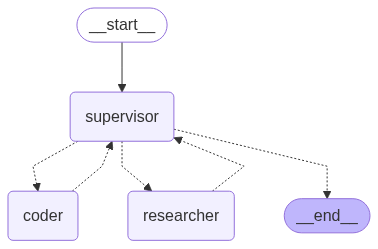

In [48]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [49]:
# With the graph created, we can now invoke it and see how it performs!
try:
      for s in app.stream({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True):
        print(s)
        print("----")
except Exception as e:
    print("Error during streaming:", e)
   

below my goto**********************************
researcher
((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:7399ca29-7ee7-6e06-d8af-8c12b8cd25ad',), {'agent': {'messages': [AIMessage(content="I can't perform math calculations, but you can find the square root of 42 using a calculator or math software. Would you like me to provide information or resources on how to calculate square roots?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 98, 'total_tokens': 139, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7a53abb7a2', 'id': 'chatcmpl-BdvqQpF3opXyIrOnNawcUp0c9h7bP', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}

In [50]:
app.invoke({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True)

below my goto**********************************
researcher
below my goto**********************************
coder
below my goto**********************************
FINISH


((),
 {'messages': [HumanMessage(content="What's the square root of 42?", additional_kwargs={}, response_metadata={}, id='8642c992-4cac-4a22-8d2f-fa38838606ca'),
   HumanMessage(content="I can't do math, but I can help you find resources or information about square roots. Would you like me to look that up?", additional_kwargs={}, response_metadata={}, name='researcher', id='aae82434-75fd-457c-9743-3b403b5f9c6c'),
   HumanMessage(content='The square root of 42 is approximately 6.4807.', additional_kwargs={}, response_metadata={}, name='coder', id='7d89bc9f-7777-495e-bfd5-cf0f35e8ee3c')],
  'next': '__end__'})

In [51]:
app.invoke({"messages": [("user", "What is an efficient Python code to get prime numbers?")]}, subgraphs=True)

below my goto**********************************
coder
below my goto**********************************
FINISH


((),
 {'messages': [HumanMessage(content='What is an efficient Python code to get prime numbers?', additional_kwargs={}, response_metadata={}, id='e0a0a892-98f7-4748-a2c5-43ef384674bc'),
   HumanMessage(content="An efficient way to generate prime numbers in Python is to use the Sieve of Eratosthenes algorithm. This algorithm is particularly effective for finding all prime numbers up to a specified integer \\( n \\). Here's a Python implementation:\n\n```python\ndef sieve_of_eratosthenes(n):\n    primes = []\n    is_prime = [True] * (n + 1)\n    is_prime[0] = is_prime[1] = False  # 0 and 1 are not primes\n\n    for p in range(2, int(n**0.5) + 1):\n        if is_prime[p]:\n            primes.append(p)\n            for multiple in range(p*p, n + 1, p):\n                is_prime[multiple] = False\n\n    # Collecting remaining primes\n    for p in range(int(n**0.5) + 1, n + 1):\n        if is_prime[p]:\n            primes.append(p)\n\n    return primes\n```\n\n### How to Use:\nYou can call 